In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import umap
import FunctionCollection as fc
import os
import torch
from torch_scatter import scatter_sum
%matplotlib notebook
import wandb
import importlib

In [17]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'OscNext_Angle_m20'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 2,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': True,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'lr': 4e-3,
        'batch_size': 512,
        'output_offset': [3.14,1.57],
        'filename': 'Nu_lvl7_1Mio_unscaled_SRT.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith',
        'TrTV': (0.1,0.99,1),#(0.025,0.995,1)
        'SRT_clean': False
       }

In [3]:
filepath = os.path.join(path, 'raw_data')

centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'width': [4.5],
                        'rqe': [1.175]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300],
                        'width': [3.5],
                        'rqe': [0.175]})
centers = centers['width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z'.split(', ')].values
scalers = scalers['width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z'.split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

from typing import List
@torch.jit.script
def batch_transform(x,events: List[int]):
    tmp_x = x.unsqueeze(1) - x
    cart = tmp_x[:,:,-3:]
    
    rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
    rho_mask = rho.squeeze() != 0
    if rho_mask.sum() != 0:
        cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
    tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)
    return torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0],x],dim=1)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
#                                event_nos = event_nos,
                               x_transform = x_transform,
                               y_transform = y_transform,
#                                batch_transform = batch_transform,
                               shuffle = True,
                               SRT_clean = args['SRT_clean'],
                              #  reweighter = ze_reweighter
                               )

In [10]:
train_loader, test_loader, val_loader = dataset.return_dataloaders(batch_size=args['batch_size'], num_workers=0)

In [18]:
import Model_Loaders.Model_20 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net()

device = torch.device('cuda')

model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [19]:
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,
#                                           ckpt = run_name + '_latest.ckpt',
                                          patience = 7
                                          )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores



  | Name        | Type        | Params
--------------------------------------------
0 | act         | SiLU        | 0     
1 | RBF_scatter | RBF_scatter | 2.3 K 
2 | decoder     | MLP         | 226 K 
--------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Restored states from the checkpoint file at C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\lr_find_temp_model.ckpt


<IPython.core.display.Javascript object>


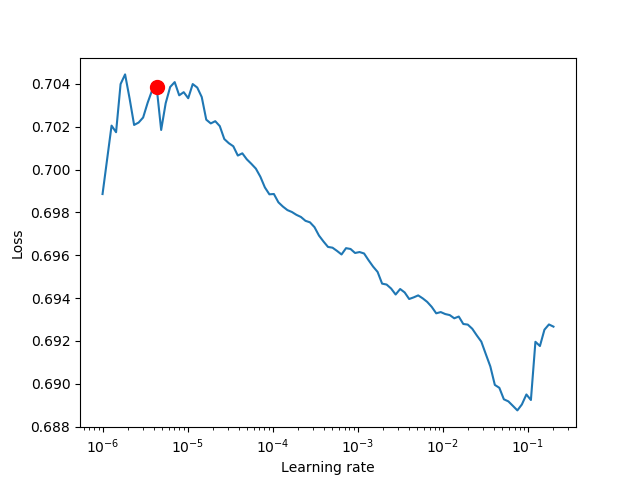

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


4.326369412620928e-06
if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [14]:
lr_finder = trainer.tuner.lr_find(model,train_loader,val_loader,min_lr=1e-6,max_lr=2e-1,num_training=100,mode='exponential',early_stop_threshold=4)

fig = lr_finder.plot(True,True)
print(lr_finder.suggestion())

args['lr'] = lr_finder.suggestion()
Net = M.Load_model(args['type'],args)
model = Net()
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,)

In [20]:
wandb_logger.experiment.config.update(args)
# wandb_logger.watch(model)
wandb_logger.experiment.log({f'lr finder, lr={lr_finder.suggestion()}': wandb.Image(fig)})

wandb: Currently logged in as: vinther901 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [21]:
trainer.fit(model, train_loader, val_loader)


  | Name        | Type        | Params
--------------------------------------------
0 | act         | SiLU        | 0     
1 | RBF_scatter | RBF_scatter | 2.3 K 
2 | decoder     | MLP         | 226 K 
--------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


C:\Users\jv97\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: Trying to log at a previous step. Use `WandbLogger(sync_step=False)` or try logging with `commit=False` when calling manually `wandb.log`.
  warnings.warn(*args, **kwargs)
wandb: WARNING Step must only increase in log calls.  Step 0 < 1; dropping {'lr-Adam': 0.0002}.


Epoch 0, global step 195: Val Acc reached 0.88454 (best 0.88454), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=0-Val Acc=0.885.ckpt" as top 1
C:\Users\jv97\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch 1, global step 391: Val Acc reached 0.79596 (best 0.79596), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=1-Val Acc=0.796.ckpt" as top 1


Epoch 2, global step 587: Val Acc reached 0.68393 (best 0.68393), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=2-Val Acc=0.684.ckpt" as top 1


Epoch 3, global step 783: Val Acc reached 0.62255 (best 0.62255), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=3-Val Acc=0.623.ckpt" as top 1


Epoch 4, global step 979: Val Acc reached 0.58270 (best 0.58270), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=4-Val Acc=0.583.ckpt" as top 1


Epoch 5, global step 1175: Val Acc reached 0.55710 (best 0.55710), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=5-Val Acc=0.557.ckpt" as top 1


Epoch 6, global step 1371: Val Acc reached 0.55158 (best 0.55158), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=6-Val Acc=0.552.ckpt" as top 1


Epoch 7, global step 1567: Val Acc reached 0.53659 (best 0.53659), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=7-Val Acc=0.537.ckpt" as top 1


Epoch 8, global step 1763: Val Acc reached 0.52094 (best 0.52094), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=8-Val Acc=0.521.ckpt" as top 1


Epoch 9, step 1959: Val Acc was not in top 1


Epoch 10, global step 2155: Val Acc reached 0.51611 (best 0.51611), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=10-Val Acc=0.516.ckpt" as top 1


Epoch 11, global step 2351: Val Acc reached 0.51216 (best 0.51216), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=11-Val Acc=0.512.ckpt" as top 1


Epoch 12, global step 2547: Val Acc reached 0.50568 (best 0.50568), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=12-Val Acc=0.506.ckpt" as top 1


Epoch 13, step 2743: Val Acc was not in top 1


Epoch 14, global step 2939: Val Acc reached 0.50188 (best 0.50188), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=14-Val Acc=0.502.ckpt" as top 1


Epoch 15, global step 3135: Val Acc reached 0.49710 (best 0.49710), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=15-Val Acc=0.497.ckpt" as top 1


Epoch 16, step 3331: Val Acc was not in top 1


Epoch 17, global step 3527: Val Acc reached 0.49164 (best 0.49164), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=17-Val Acc=0.492.ckpt" as top 1


Epoch 18, step 3723: Val Acc was not in top 1


Epoch 19, step 3919: Val Acc was not in top 1


Epoch 20, step 4115: Val Acc was not in top 1


Epoch 21, step 4311: Val Acc was not in top 1


Epoch 22, global step 4507: Val Acc reached 0.49087 (best 0.49087), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=22-Val Acc=0.491.ckpt" as top 1


Epoch 23, step 4703: Val Acc was not in top 1


Epoch 24, step 4899: Val Acc was not in top 1


Epoch 25, step 5095: Val Acc was not in top 1


Epoch 26, step 5291: Val Acc was not in top 1


Epoch 27, step 5487: Val Acc was not in top 1


Epoch 28, step 5683: Val Acc was not in top 1


Epoch 29, global step 5879: Val Acc reached 0.48988 (best 0.48988), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=29-Val Acc=0.490.ckpt" as top 1


Epoch 30, step 6075: Val Acc was not in top 1


Epoch 31, step 6271: Val Acc was not in top 1


Epoch 32, step 6467: Val Acc was not in top 1


Epoch 33, step 6663: Val Acc was not in top 1


Epoch 34, global step 6859: Val Acc reached 0.48931 (best 0.48931), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\OscNext_Angle_m20_3klp\OscNext_Angle_m20-epoch=34-Val Acc=0.489.ckpt" as top 1


Epoch 35, step 7055: Val Acc was not in top 1


Epoch 36, step 7251: Val Acc was not in top 1


Epoch 37, step 7447: Val Acc was not in top 1


Epoch 38, step 7643: Val Acc was not in top 1


Epoch 39, step 7839: Val Acc was not in top 1


Epoch 40, step 8035: Val Acc was not in top 1


Epoch 41, step 8231: Val Acc was not in top 1


1

In [22]:
trainer.save_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
print("potentially remember wandb.finish()")

potentially remember wandb.finish()


In [25]:
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
# model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/oscnext_AngleO_m12-epoch=111-Val Acc=0.727.ckpt')
# model.to(device);

Net(
  (act): SiLU()
  (RBF_scatter): RBF_scatter(
    (RBF_batch_norm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (RBF): RBF()
    (sum_batch_norm): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=640, out_features=320, bias=True)
      (1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=320, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)

In [32]:
pred, truth = fc.return_reco_truth(model,val_loader)

Batch: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


<IPython.core.display.Javascript object>


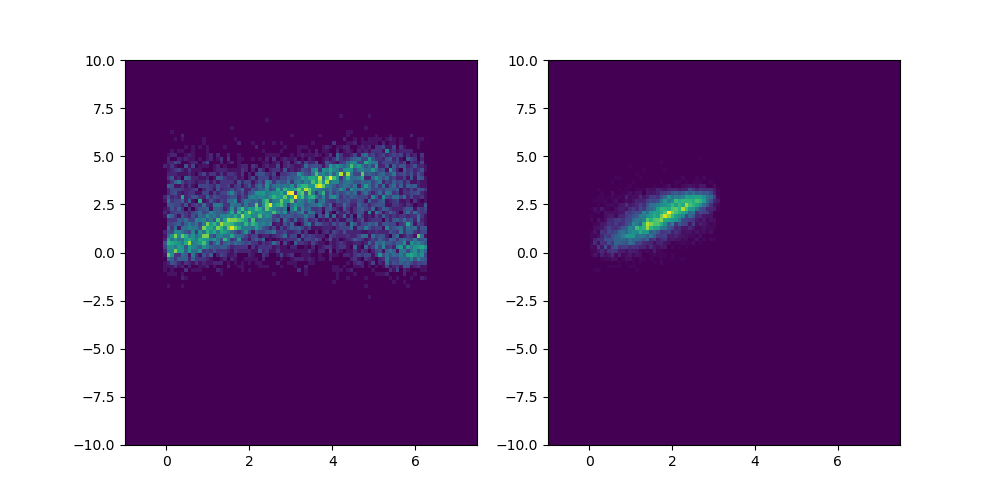

<IPython.core.display.Javascript object>


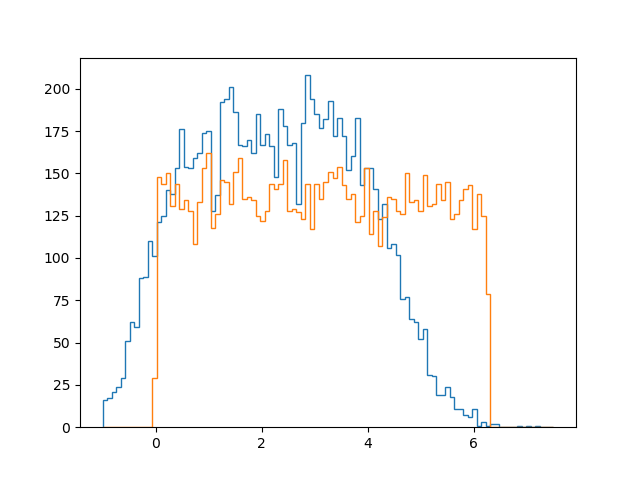

<IPython.core.display.Javascript object>


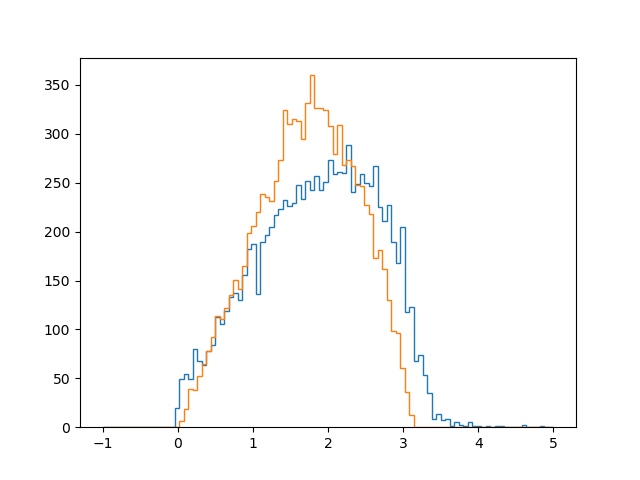

In [35]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)

ax[0].hist2d(truth[:,0],pred[:,0]+3.14,bins=100,range=((-1,7.5),(-10,10)))
ax[1].hist2d(truth[:,1],pred[:,1]+1.57,bins=100,range=((-1,7.5),(-10,10)));

fig, ax = plt.subplots()
ax.hist(pred[:,0]+3.14,bins=100,range=(-1,7.5),histtype='step');
ax.hist(truth[:,0],bins=100,range=(-1,7.5),histtype='step');

fig, ax = plt.subplots()
ax.hist(abs(pred[:,1]+1.57),bins=100,range=(-1,2*2.5),histtype='step');
ax.hist(truth[:,1],bins=100,range=(-1,2*2.5),histtype='step');


In [40]:
dataset[dataset.event_nos[:100].tolist()]

IndexError: index 18183191 is out of bounds for axis 0 with size 1000000

In [48]:
val = dataset.collate(dataset.val()[[_ for _ in range(dataset.val().__len__())]])

In [51]:
yumap = umap.UMAP(verbose=1)

emb = yumap.fit_transform(model.RBF_scatter(val.x.float(),val.batch).detach())

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=1)
Construct fuzzy simplicial set
Wed Apr 21 14:44:59 2021 Finding Nearest Neighbors
Wed Apr 21 14:44:59 2021 Building RP forest with 10 trees
Wed Apr 21 14:45:01 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
Wed Apr 21 14:45:12 2021 Finished Nearest Neighbor Search
Wed Apr 21 14:45:14 2021 Construct embedding
	comple

<IPython.core.display.Javascript object>


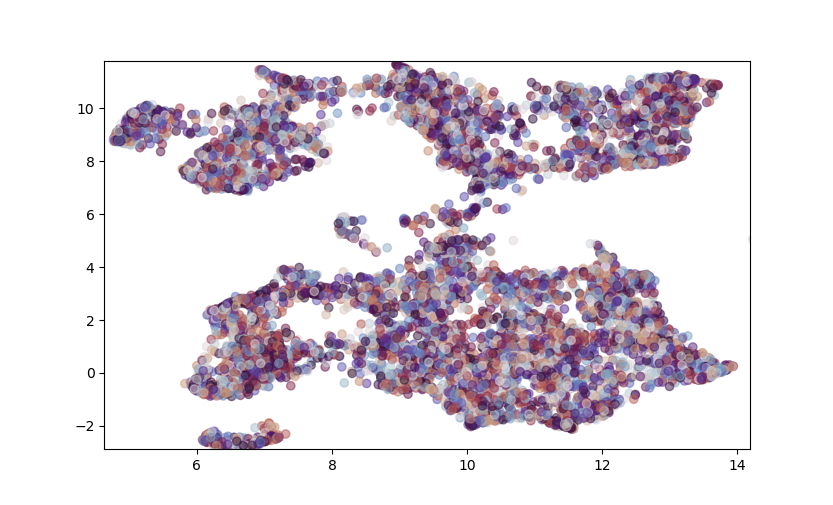

In [53]:
fig, ax = plt.subplots()
color = val.y.view(-1,2)[:,0]

ax.scatter(emb[:,0],emb[:,1], c = color, cmap='twilight',alpha=0.5)

In [26]:
yumap = umap.UMAP()

emb = yumap.fit_transform(model.RBF_scatter.RBF.centres.clone().detach())

<IPython.core.display.Javascript object>


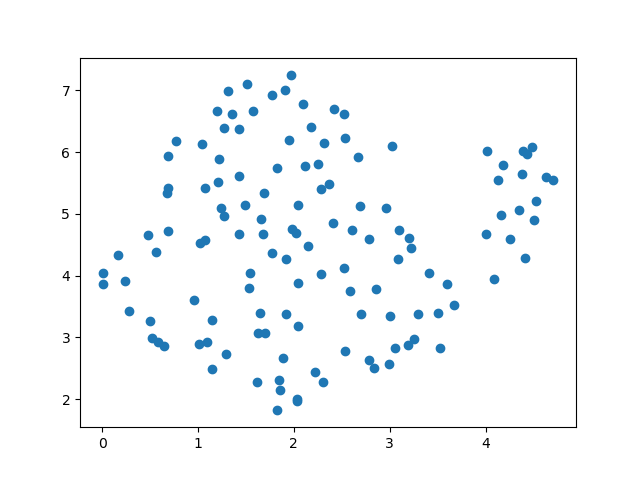

<IPython.core.display.Javascript object>


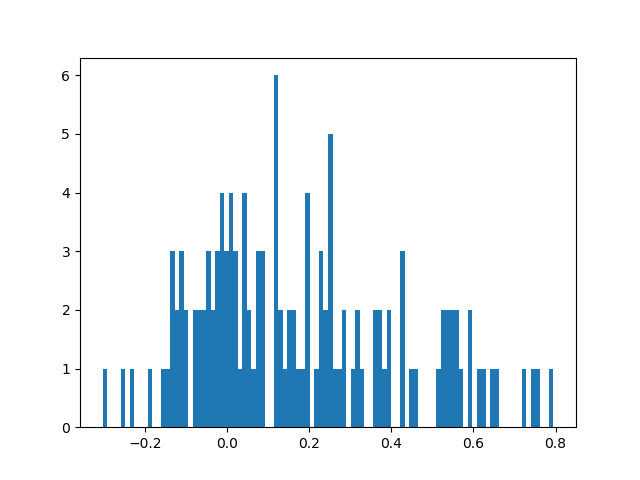

In [27]:
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])

fig, ax = plt.subplots()
ax.hist(model.RBF_scatter.RBF.log_sigmas.clone().detach(),bins=100);

In [36]:
wandb.finish()

_runtime,2708
_timestamp,1619008832
_step,8231
Train Loss,-0.17153
Train Acc,0.45582
epoch,41
Val Acc,0.49287
lr-Adam,0.00094


_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,██▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▃▂▂▃▃▂▃▂▂▁▂▂▂▁▂▂▂
Train Acc,█▆▆▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▃▂▂▂▂▁▂▂▂▁▂▁▁▁▁▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Val Acc,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁


In [111]:
N = 1000
data = dataset.collate(dataset[np.random.choice(dataset.__len__(),N).tolist()])

In [142]:
def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi
def r(alpha):
    return alpha
def t(alpha):
    return (1 + alpha.pow(2)).pow(-1)

class RBF(torch.nn.Module):
    def __init__(self, in_features, out_features, basis_func=gaussian):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_sigmas = torch.nn.Parameter(torch.Tensor(out_features))
#         self.sigmas = torch.nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.normal_(self.centres, 0, 1)
        torch.nn.init.constant_(self.log_sigmas, 0)
#         torch.nn.init.constant_(self.sigmas, 10)

    def forward(self, x):
        size = (x.size(0), self.out_features, self.in_features)
        x = x.unsqueeze(1).expand(size)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5) / torch.exp(self.log_sigmas).unsqueeze(0)
#         distances = (x - c).pow(2).sum(-1) / self.sigmas.unsqueeze(0)
#         print(distances.mean(), distances.std(), distances.min(), distances.max())
        return self.basis_func(distances)
#         return distances

# rbf = RBF(7,64*4)
class RBF_scatter(torch.nn.Module):
    def __init__(self, in_features, out_features,basis_func=gaussian):
        super(RBF_scatter, self).__init__() 
        self.RBF_batch_norm = torch.nn.BatchNorm1d(in_features)
        self.RBF = RBF(in_features, out_features,basis_func)
        self.sum_batch_norm = torch.nn.BatchNorm1d(out_features)
    def forward(self, x, batch):
        return self.sum_batch_norm(scatter_sum(self.RBF(self.RBF_batch_norm(x.float())), batch, dim=0))

scatter = RBF_scatter(data.x.shape[1],4*64,basis_func=t)

In [107]:
help(umap.UMAP)

Help on class UMAP in module umap.umap_:

class UMAP(sklearn.base.BaseEstimator)
 |  UMAP(n_neighbors=15, n_components=2, metric='euclidean', metric_kwds=None, output_metric='euclidean', output_metric_kwds=None, n_epochs=None, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1.0, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, random_state=None, angular_rp_forest=False, target_n_neighbors=-1, target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=42, force_approximation_algorithm=False, verbose=False, unique=False)
 |  
 |  Uniform Manifold Approximation and Projection
 |  
 |  Finds a low dimensional embedding of the data that approximates
 |  an underlying manifold.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors: float (optional, default 15)
 |      The size of local neighborhood (in terms of number of neighboring
 |      sample points

In [143]:
yumap = umap.UMAP(verbose=1, metric='euclidean')

# emb = yumap.fit_transform(scatter_sum(scatter.RBF(data.x),data.batch,dim=0).detach())
emb = yumap.fit_transform(scatter(data.x,data.batch).detach())

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=1)
Construct fuzzy simplicial set
Wed Apr 21 12:23:00 2021 Finding Nearest Neighbors
Wed Apr 21 12:23:00 2021 Finished Nearest Neighbor Search
Wed Apr 21 12:23:00 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  3

<IPython.core.display.Javascript object>


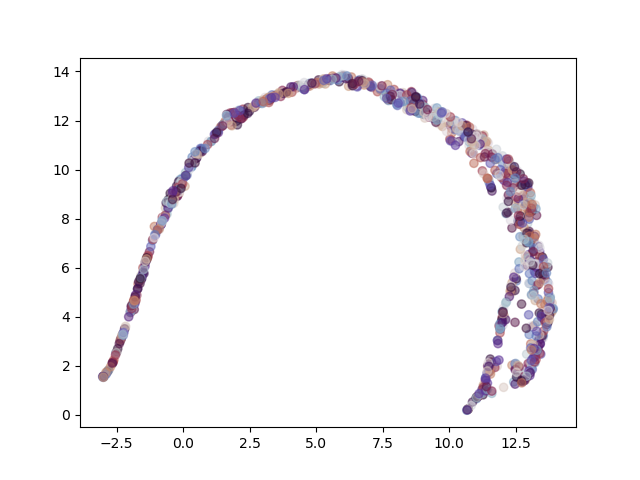

In [144]:
fig, ax = plt.subplots()

color = data.y.view(-1,2)[:,0]
# color = data.batch

ax.scatter(emb[:,0],emb[:,1], c = color, cmap='twilight',alpha=0.5)

In [77]:
yumap = umap.UMAP(verbose=1)

# emb = yumap.fit_transform(data.x)
emb = yumap.fit_transform(data.x,y=data.batch)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=1)
Construct fuzzy simplicial set
Wed Apr 21 11:47:12 2021 Finding Nearest Neighbors
Wed Apr 21 11:47:12 2021 Finished Nearest Neighbor Search
Wed Apr 21 11:47:12 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  3

In [69]:
import torch
from typing import Optional
from torch_scatter import scatter_sum, scatter_min, scatter_max
from torch_scatter.utils import broadcast

@torch.jit.script
def scatter_distribution(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                        out: Optional[torch.Tensor] = None,
                        dim_size: Optional[int] = None,
                        unbiased: bool = True) -> torch.Tensor:

    if out is not None:
        dim_size = out.size(dim)

    if dim < 0:
        dim = src.dim() + dim

    count_dim = dim
    if index.dim() <= dim:
        count_dim = index.dim() - 1

    ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
    count = scatter_sum(ones, index, count_dim, dim_size=dim_size)

    index = broadcast(index, src, dim)
    tmp = scatter_sum(src, index, dim, dim_size=dim_size)
    count = broadcast(count, tmp, dim).clamp(1)
    mean = tmp.div(count)

    var = (src - mean.gather(dim, index))
    var = var * var
    var = scatter_sum(var, index, dim, out, dim_size)

    if unbiased:
        count = count.sub(1).clamp_(1)
    var = var.div(count)
    maximum = scatter_max(src, index, dim, out, dim_size)[0]
    minimum = scatter_min(src, index, dim, out, dim_size)[0]

    return torch.cat([mean,var,maximum,minimum],dim=1)
scatter_distribution(data.x,data.batch,dim=0)

tensor([[-2.3810e-01,  8.0952e-01,  3.4280e+00, -1.7364e-01,  1.2248e-01,
         -1.9906e-02, -1.4713e+00,  9.9048e-01,  3.6190e-01,  2.2002e+00,
          1.7225e-02,  1.7733e-02,  2.1116e-02,  2.8565e-02,  1.0000e+00,
          1.0000e+00,  5.8684e+00,  1.2004e-01,  3.7730e-01,  1.1830e-01,
         -1.0234e+00, -1.0000e+00, -1.0000e+00,  9.4419e-01, -3.0604e-01,
         -3.6567e-02, -2.6500e-01, -1.6308e+00],
        [-5.7143e-01,  8.5714e-01,  3.5496e+00, -1.5052e-01,  4.4024e-03,
         -2.5519e-01, -7.2622e-01,  6.9841e-01,  2.7513e-01,  7.3368e+00,
          4.5147e-02,  6.8290e-03,  5.9851e-03,  3.8444e-03,  1.0000e+00,
          1.0000e+00,  1.4440e+01,  4.6906e-01,  2.4123e-01,  1.1830e-01,
         -6.1483e-01, -1.0000e+00, -1.0000e+00,  5.7944e-01, -3.0345e-01,
         -3.2267e-02, -3.5173e-01, -8.7180e-01],
        [ 2.9412e-01,  6.4706e-01,  3.2400e+00, -7.5998e-02,  3.4296e-01,
         -1.9055e-01, -1.1360e+00,  9.7059e-01,  6.1765e-01,  2.4990e+00,
          7.31

<IPython.core.display.Javascript object>


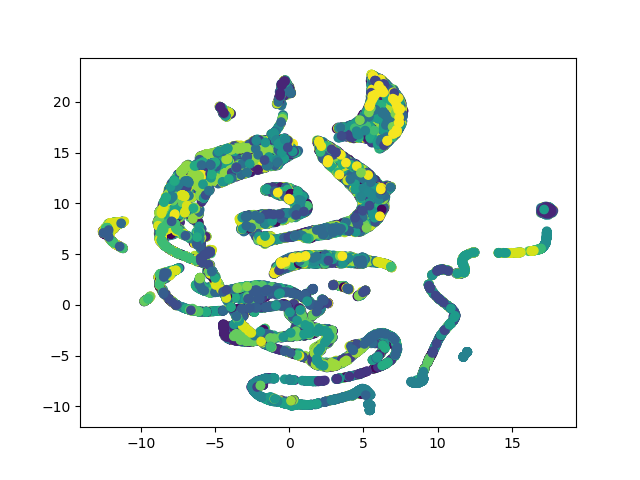

In [126]:
fig, ax = plt.subplots()

color = data.y.view(-1,2)[:,0].gather(0,data.batch)
# color = data.batch

ax.scatter(emb[:,0],emb[:,1], c = color)